# Analyze Data - Correlation Analysis

**Table of Contents**
1. [Intro](#1.-Intro)
2. [Jointplot](#2.-Jointplot)

## 1. Intro
From the Scattergeo Plot and Choropleth Map, we have seen the distribution of the areas showing decreased teen population and the schools with enrollment decline. In this part, we will further calculate the student-teacher ratio (STR). We want to know the relationship between the STR and enrollment and the relationship between the students taking SAT and enrollment. We also want to see if there is a regional difference between the scope of US and the regions with teenage population decrease.

Seaborn is a data visualization library, and we will use it to generate Jointplots for visualizing the correlation between variables. First, we’ll create jointplots for the 5-year changes of STR and enrollment. Second, we'll create jointplots for the 5-year means of the students taking SAT and enrollment.

**Note: Seaborn must be installed for this Jupiter Notebook.**

## 2. JointPlot
To create JointPlots with Seaborn, it takes steps as follows:
1. Prerequisites
2. Data Preparation
3. Plotting

### 2.1 Prerequisites
Installing the necessary packages and load data

In [62]:
import pandas as pd
import numpy as np
import censusdata
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Load the education data
df_2013 = pd.read_csv('./educationdata/school_dir_2013.csv')
df_2015 = pd.read_csv('./educationdata/school_dir_2015.csv')
df_2017 = pd.read_csv('./educationdata/school_dir_2017.csv')

df_2013.drop('Unnamed: 0', axis = 1, inplace = True)
df_2015.drop('Unnamed: 0', axis = 1, inplace = True)

In [64]:
# Load the census data
def import_censusdata(year, variables):
    census_data = censusdata.download('acs5', year, 
                                censusdata.censusgeo([('state','*'), ('county', '*')]), variables)

    dictionary = {'B02001_001E':'Total Pop Estimate', 'B01001_006E':'Males 15-17', 'B01001_030E':'Females 15-17',\
                  'B01001A_006E':'White Males 15-17','B01001B_006E':'Black Males 15-17', 'B01001I_006E':'Hispanic Males 15-17',\
                   'B19001_001E':'HHI', 'B19001_016E':'HHI 150K-200K','B19001A_001E':'HHI 220K+'}
    census_data.rename(columns =dictionary, inplace=True)
    df = pd.DataFrame(census_data)

    new_indices = []
    county_names = []
    for index in df.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(',')[0]
        county_names.append(county_name)
    df.index = new_indices
    df['county_name'] = county_names
    
    return df

census_2013 = import_censusdata(2013, ['B02001_001E', 'B01001_006E', 'B01001_030E'])
census_2015 = import_censusdata(2015, ['B02001_001E', 'B01001_006E', 'B01001_030E'])
census_2017 = import_censusdata(2017, ['B02001_001E', 'B01001_006E', 'B01001_030E'])

census_2013['teen_pop'] = census_2013['Males 15-17'] + census_2013['Females 15-17']
census_2015['teen_pop'] = census_2015['Males 15-17'] + census_2015['Females 15-17']
census_2017['teen_pop'] = census_2017['Males 15-17'] + census_2017['Females 15-17']

census_2013.reset_index(inplace=True)
census_2015.reset_index(inplace=True)
census_2017.reset_index(inplace=True)

census_2013 = census_2013.rename(columns = {'index':'county_code'})
census_2015 = census_2015.rename(columns = {'index':'county_code'})
census_2017 = census_2017.rename(columns = {'index':'county_code'})

### 2.2 Data Preparation
At this step, we do the following:
1. Uniform the ncessch column to 12-digit string as the key for merging the dataframes
2. Calculate the STR and drop the outliers
3. Merge the school tables of each year,  and calculate the 5-year trend of enrollment, students taking SAT and STR
4. For the census data, calculate the 5-year trend of teenage population
5. Merge the school data and the census data 

In [65]:
# Uniform the ncessch column to 12-digit string as the key for merging the dataframes
df_2013.ncessch = df_2013.ncessch.astype(str).str.zfill(12)
df_2015.ncessch = df_2015.ncessch.astype(str).str.zfill(12)
df_2017.ncessch = df_2017.ncessch.astype(str).str.zfill(12)

In [66]:
# Calculate the STR and drop the outliers
def student_teacher_ratio(df):
    df['student_teacher_ratio'] = (df['enrollment'] / df['teachers_fte']).round(2)
    df = df.drop(index = df[(df['student_teacher_ratio'] < 5) | (df['student_teacher_ratio'] > 50)].index) 
    df = df.drop(index = df[(df['enrollment'] <50) | (df['teachers_fte'] < 5) | (df['teachers_fte'] > 300)].index)
    return df

df_2013 = student_teacher_ratio(df_2013)
df_2015 = student_teacher_ratio(df_2015)
df_2017 = student_teacher_ratio(df_2017)


In [67]:
# Merge the tables of each year,  and calculate the 5-year trend of enrollment, students taking SAT and STR
er_13to17 = df_2017[['ncessch', 'school_name', 'city_location', 'state_location', 'county_code', 'enrollment', 'student_teacher_ratio', 'students_SAT_ACT']].merge(df_2015[['ncessch', 'enrollment', 'student_teacher_ratio', 'students_SAT_ACT']], on = 'ncessch', how = 'left')
er_13to17 = er_13to17.merge(df_2013[['ncessch', 'enrollment', 'student_teacher_ratio', 'students_SAT_ACT']], on = 'ncessch', how = 'left')
er_13to17 = er_13to17.rename(columns = {'enrollment_x':'enrollment_count_2017', 'enrollment_y':'enrollment_count_2015','enrollment':'enrollment_count_2013',\
                                        'student_teacher_ratio_x':'student_teacher_ratio_2017', 'student_teacher_ratio_y':'student_teacher_ratio_2015','student_teacher_ratio':'student_teacher_ratio_2013',\
                                        'students_SAT_ACT_x':'SAT_ACT_2017', 'students_SAT_ACT_y':'SAT_ACT_2015','students_SAT_ACT':'SAT_ACT_2013'})
er_13to17.dropna(inplace=True)
er_13to17['er_13to17_mean'] = ((er_13to17['enrollment_count_2017'] + er_13to17["enrollment_count_2015"] + er_13to17['enrollment_count_2013']) / 3).round(0) 
er_13to17['er_13to17_cg'] = (er_13to17['enrollment_count_2017'] - er_13to17['er_13to17_mean'])
er_13to17['er_13to17_cgp'] = ((er_13to17['enrollment_count_2017'] - er_13to17['er_13to17_mean']) / er_13to17['er_13to17_mean']).round(2) * 100
er_13to17['str_13to17_mean'] = ((er_13to17['student_teacher_ratio_2017'] + er_13to17["student_teacher_ratio_2015"] + er_13to17['student_teacher_ratio_2013']) / 3 ).round(2)
er_13to17['str_13to17_cg'] = (er_13to17['student_teacher_ratio_2017'] - er_13to17['str_13to17_mean'])
er_13to17['str_13to17_cgp'] = ((er_13to17['student_teacher_ratio_2017'] - er_13to17['str_13to17_mean']) / er_13to17['str_13to17_mean']).round(2) * 100
er_13to17['sat_13to17_mean'] = ((er_13to17['SAT_ACT_2017'] + er_13to17["SAT_ACT_2015"] + er_13to17['SAT_ACT_2013']) / 3 ).round(2)
er_13to17['sat_13to17_cg'] = (er_13to17['SAT_ACT_2017'] - er_13to17['sat_13to17_mean'])
er_13to17['sat_13to17_cgp'] = ((er_13to17['SAT_ACT_2017'] - er_13to17['sat_13to17_mean']) / er_13to17['sat_13to17_mean']).round(2) * 100
er_13to17.head()

,ncessch,school_name,city_location,state_location,county_code,enrollment_count_2017,student_teacher_ratio_2017,SAT_ACT_2017,enrollment_count_2015,student_teacher_ratio_2015,...,SAT_ACT_2013,er_13to17_mean,er_13to17_cg,er_13to17_cgp,str_13to17_mean,str_13to17_cg,str_13to17_cgp,sat_13to17_mean,sat_13to17_cg,sat_13to17_cgp
0,010000500871,Albertville High School,Albertville,AL,1095,1436.0,18.65,363.0,1290.0,19.25,...,242.0,1281.0,155.0,12.0,18.45,0.20,1.0,303.00,60.00,20.0
2,010000600878,Douglas High School,Douglas,AL,1095,591.0,19.70,142.0,593.0,19.13,...,165.0,577.0,14.0,2.0,18.48,1.22,7.0,196.67,-54.67,-28.0
3,010000600883,Kate D Smith DAR High School,Grant,AL,1095,449.0,18.71,103.0,457.0,18.28,...,202.0,456.0,-7.0,-2.0,17.84,0.87,5.0,179.00,-76.00,-42.0
4,010000601585,Brindlee Mountain High School,Guntersville,AL,1095,359.0,11.58,76.0,358.0,18.84,...,86.0,361.0,-2.0,-1.0,15.01,-3.43,-23.0,111.33,-35.33,-32.0
5,010000700251,Hoover High School,Hoover,AL,1073,2891.0,14.31,1189.0,2902.0,14.44,...,1084.0,2854.0,37.0,1.0,14.32,-0.01,-0.0,1169.33,19.67,2.0


In [68]:
# Calculate the 5-year trend of teenage population
census_13to17 = census_2017[['county_code', 'teen_pop']].merge(census_2015[['county_code', 'teen_pop']], on = 'county_code', how = 'left')
census_13to17 = census_13to17.merge(census_2013[['county_code', 'teen_pop']], on = 'county_code', how = 'left')
census_13to17 = census_13to17.rename(columns = {'teen_pop_x':'teen_pop_2017', 'teen_pop_y':'teen_pop_2015','teen_pop':'teen_pop_2013'})
census_13to17['teenpop_13to17_mean'] = ((census_13to17['teen_pop_2017'] + census_13to17["teen_pop_2015"] + census_13to17['teen_pop_2013']) / 3 ).round(0)
census_13to17['teenpop_13to17_cg'] = (census_13to17['teen_pop_2017'] - census_13to17['teenpop_13to17_mean'])
census_13to17['teenpop_13to17_cgp'] = ((census_13to17['teen_pop_2017'] - census_13to17['teenpop_13to17_mean']) / census_13to17['teenpop_13to17_mean']).round(2) * 100
census_13to17.head()

,county_code,teen_pop_2017,teen_pop_2015,teen_pop_2013,teenpop_13to17_mean,teenpop_13to17_cg,teenpop_13to17_cgp
0,47177,1634,1567,1517.0,1573.0,61.0,4.0
1,47179,4283,4234,4180.0,4232.0,51.0,1.0
2,47183,1206,1212,1236.0,1218.0,-12.0,-1.0
3,47005,677,680,647.0,668.0,9.0,1.0
4,47007,495,569,583.0,549.0,-54.0,-10.0


In [69]:
# Merge the school data and the census data 
census_13to17.county_code = census_13to17.county_code.astype(str).str.zfill(5)
er_13to17.county_code = er_13to17.county_code.astype(str).str.zfill(5)
er_13to17 = er_13to17.merge(census_13to17, on = 'county_code', how = 'left')
er_13to17.teenpop_13to17_cgp = er_13to17.teenpop_13to17_cgp.astype(int)
er_13to17.str_13to17_cgp = er_13to17.str_13to17_cgp.astype(int)
er_13to17 = er_13to17.drop(index = er_13to17[(er_13to17['SAT_ACT_2017'] == 0) & (er_13to17['SAT_ACT_2015'] == 0) & (er_13to17['SAT_ACT_2013'] == 0)].index) 
er_13to17.head()

,ncessch,school_name,city_location,state_location,county_code,enrollment_count_2017,student_teacher_ratio_2017,SAT_ACT_2017,enrollment_count_2015,student_teacher_ratio_2015,...,str_13to17_cgp,sat_13to17_mean,sat_13to17_cg,sat_13to17_cgp,teen_pop_2017,teen_pop_2015,teen_pop_2013,teenpop_13to17_mean,teenpop_13to17_cg,teenpop_13to17_cgp
0,010000500871,Albertville High School,Albertville,AL,01095,1436.0,18.65,363.0,1290.0,19.25,...,1,303.00,60.00,20.0,4026,3890,3906.0,3941.0,85.0,2
1,010000600878,Douglas High School,Douglas,AL,01095,591.0,19.70,142.0,593.0,19.13,...,7,196.67,-54.67,-28.0,4026,3890,3906.0,3941.0,85.0,2
2,010000600883,Kate D Smith DAR High School,Grant,AL,01095,449.0,18.71,103.0,457.0,18.28,...,5,179.00,-76.00,-42.0,4026,3890,3906.0,3941.0,85.0,2
3,010000601585,Brindlee Mountain High School,Guntersville,AL,01095,359.0,11.58,76.0,358.0,18.84,...,-23,111.33,-35.33,-32.0,4026,3890,3906.0,3941.0,85.0,2
4,010000700251,Hoover High School,Hoover,AL,01073,2891.0,14.31,1189.0,2902.0,14.44,...,0,1169.33,19.67,2.0,25168,25077,25673.0,25306.0,-138.0,-1


**Note: We select the teenage population decreasing area with the definition of a 5% decrease**

In [70]:
df_decline_13to17 = er_13to17[er_13to17['teenpop_13to17_cgp'] < -5]
df_decline_13to17

,ncessch,school_name,city_location,state_location,county_code,enrollment_count_2017,student_teacher_ratio_2017,SAT_ACT_2017,enrollment_count_2015,student_teacher_ratio_2015,...,str_13to17_cgp,sat_13to17_mean,sat_13to17_cg,sat_13to17_cgp,teen_pop_2017,teen_pop_2015,teen_pop_2013,teenpop_13to17_mean,teenpop_13to17_cg,teenpop_13to17_cgp
59,010072000298,Clarke County High School,Grove Hill,AL,01025,383.0,18.24,54.0,368.0,16.00,...,8,122.67,-68.67,-56.0,1088,1159,1222.0,1156.0,-68.0,-6
60,010072001493,Jackson High School,Jackson,AL,01025,516.0,17.20,201.0,594.0,18.56,...,-5,180.33,20.67,11.0,1088,1159,1222.0,1156.0,-68.0,-6
61,010075002210,Central High School of Clay County,Lineville,AL,01027,577.0,16.49,143.0,666.0,18.00,...,-8,179.33,-36.33,-20.0,516,578,566.0,553.0,-37.0,-7
67,010087001766,Hillcrest High School,Evergreen,AL,01035,418.0,46.44,87.0,411.0,24.18,...,66,87.67,-0.67,-1.0,464,505,543.0,504.0,-40.0,-8
68,010090001749,Central High School,Rockford,AL,01037,273.0,21.00,45.0,314.0,22.43,...,-3,70.00,-25.00,-36.0,372,400,441.0,404.0,-32.0,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13615,560377000187,Buffalo High School,Buffalo,WY,56019,313.0,11.59,59.0,322.0,10.39,...,6,75.00,-16.00,-21.0,270,300,363.0,311.0,-41.0,-13
13626,560483000263,Newcastle High School,Newcastle,WY,56045,207.0,9.86,97.0,232.0,10.09,...,-3,71.00,26.00,37.0,221,233,283.0,246.0,-25.0,-10
13627,560486000267,Pinedale High School,Pinedale,WY,56035,283.0,13.48,73.0,260.0,12.38,...,0,74.33,-1.33,-2.0,287,426,476.0,396.0,-109.0,-28
13638,560583000335,Jackson Hole High School,Jackson,WY,56039,679.0,13.86,163.0,638.0,13.29,...,8,54.33,108.67,200.0,502,751,785.0,679.0,-177.0,-26


### 2.3 Plotting
We’ll create Jointplots with Seabron. At this step, we do the following:
1. Select the data for plotting
2. Add customizations as needed

We design the jointplots for visualizing both the distribution and relationship of the Student-Teacher-ratio (STR) and enrollment. 
STR is the number of students who attend a school divided by the number of teachers in the institution and is often used as a proxy for class size. A low STR is often taken as a selling point for choosing schools. On the other hand, high STR is often cited for criticizing proportionately underfunded schools or as evidence of the need for legislative change or more funding for education. Maintaining a balancing STR is vital for high school to sustain, which means a staff change in responding to the enrollment change. 


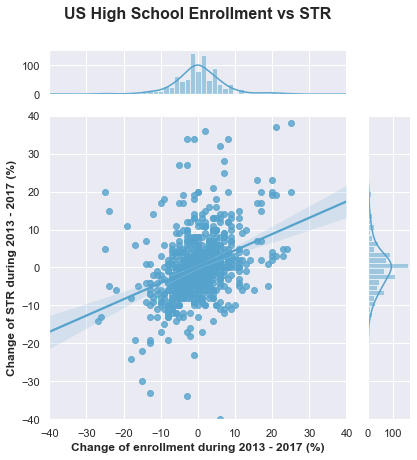

In [71]:
# Set the style and palette for rendering
sns.set(style="darkgrid")
sns.set_palette("icefire")
# Plotting 
J1 = sns.jointplot(data=er_13to17.sample(900, weights = 'student_teacher_ratio_2017'), 
              x="er_13to17_cgp", y="str_13to17_cgp",
              kind="reg", marginal_ticks=True,  
              xlim = (-40, 40), ylim = (-40, 40), space = 0.5,
              )
J1.ax_joint.set_xlabel('Change of enrollment during 2013 - 2017 (%)', fontweight = 'bold', fontsize = 12)
J1.ax_joint.set_ylabel('Change of STR during 2013 - 2017 (%)', fontweight = 'bold', fontsize = 12)
J1.ax_joint.set_title('US High School Enrollment vs STR', fontsize=16, fontweight='bold', y=1.3,loc="center")
J1.savefig('./plots/us_str_enr.png', dpi=200)
plt.show()

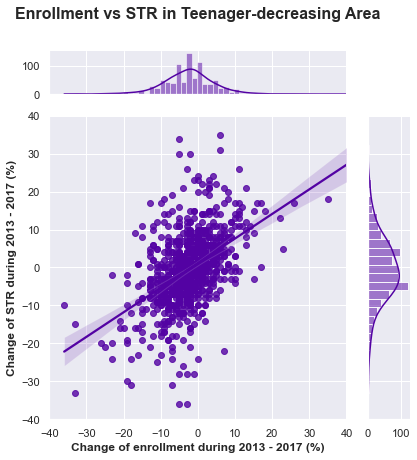

In [72]:
sns.set_palette("plasma")
J2 = sns.jointplot(data=df_decline_13to17,
              x="er_13to17_cgp", y="str_13to17_cgp",
              kind="reg", marginal_ticks=True, 
              xlim = (-40, 40), ylim = (-40, 40),space=0.5
              )
J2.ax_joint.set_xlabel('Change of enrollment during 2013 - 2017 (%)', fontweight = 'bold', fontsize = 12)
J2.ax_joint.set_ylabel('Change of STR during 2013 - 2017 (%)', fontweight = 'bold', fontsize = 12)
J2.ax_joint.set_title('Enrollment vs STR in Teenager-decreasing Area', fontsize=16, fontweight='bold', y=1.3,loc="center")
J2.savefig('./plots/dc_str_enr.png', dpi=200)
plt.show()

This pair of Jointplots about enrollment and STR
* joints the distribution of the change in both STR and enrollment
* demonstrates the positive linear relationship between STR and enrollment
* reveals the regional difference between the national data and regional data from the teenager-decreasing areas

The STR and enrollment have a weak positive linear correlation at the national level, suggesting a balance by the floating dynamic of teaching staff. However, the correlation is more robust in the population declining areas. We can probably infer that schools in regions with decreasing teenagers are more vulnerable to enrollment decline. 

 We also want to visualize the distribution and relationship of the students taking SAT and enrollment. The SAT is a standardized test widely used for college admissions in the US. The more students take the SAT, the more outstanding a school is in offering a chance for tertiary education. Students usually take the SAT during grade 11  or 12, and fewer students take the SAT before grade 11.

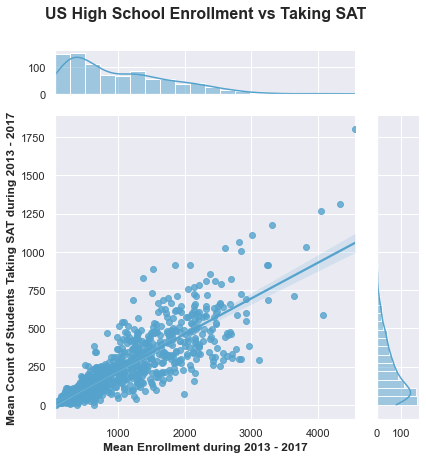

In [73]:
sns.set_palette("icefire")
J3 = sns.jointplot(data=er_13to17.sample(900, weights = 'student_teacher_ratio_2017'), 
              x="er_13to17_mean", y="sat_13to17_mean",
              kind="reg", marginal_ticks=True,  
              space = 0.5,
              )
J3.ax_joint.set_xlabel('Mean Enrollment during 2013 - 2017', fontweight = 'bold', fontsize = 12)
J3.ax_joint.set_ylabel('Mean Count of Students Taking SAT during 2013 - 2017', fontweight = 'bold', fontsize = 12)
J3.ax_joint.set_title('US High School Enrollment vs Taking SAT', fontsize=16, fontweight='bold', y=1.3,loc="center")
J3.savefig('./plots/us_sat_enr.png', dpi=200)
plt.show()

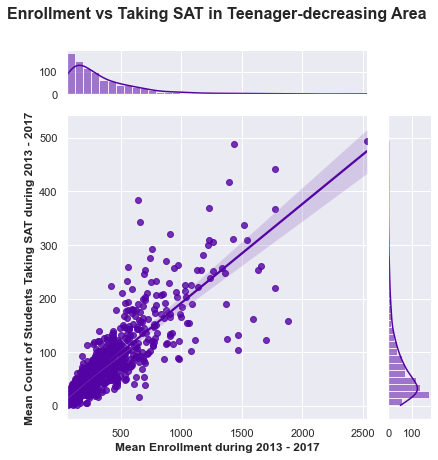

In [74]:
sns.set_palette("plasma")
J4 = sns.jointplot(data=df_decline_13to17,
              x="er_13to17_mean", y="sat_13to17_mean",
              kind="reg", marginal_ticks=True, 
              space=0.5
              )
J4.ax_joint.set_xlabel('Mean Enrollment during 2013 - 2017', fontweight = 'bold', fontsize = 12)
J4.ax_joint.set_ylabel('Mean Count of Students Taking SAT during 2013 - 2017', fontweight = 'bold', fontsize = 12)
J4.ax_joint.set_title('Enrollment vs Taking SAT in Teenager-decreasing Area', fontsize=16, fontweight='bold', y=1.3,loc="center")
J4.savefig('./plots/dc_sat_enr.png', dpi=200)
plt.show()

This pair of Jointplots about enrollment and students taking SAT
* joints the distribution of the 5-year mean in both students taking SAT and enrollment
* demonstrates the positive linear relationship between students taking SAT and enrollment
* reveals the regional difference between the national data and regional data from the teenager-decreasing areas

We see a rapid decline in enrollment in some schools—however, the number of students taking SAT delays responding to the change. It's more reasonable to use the 5-year means of both variables for analyzing their correlation. The result reveals that students taking the SAT and enrollment have a weaker positive linear correlation at the national level, suggesting compensation by the floating dynamic of students. However, the correlation is more significant in the population declining areas.